In [1]:
import glob, os
import dicom_numpy
import dicom
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
import numpy as np
import collections

In [2]:
def extract_voxel_data(list_of_dicom_files):
    datasets = [dicom.read_file(f) for f in list_of_dicom_files]
    try:
        voxel_ndarray, ijk_to_xyz, slices = dicom_numpy.combine_slices(datasets)
    except dicom_numpy.DicomImportException as e:
        # invalid DICOM data
        raise
    return voxel_ndarray, slices

In [3]:
def generate_labels_from_xml(xml, shape_to_return, k_to_z):
    labeled = np.zeros(shape_to_return)
    
    tree = ET.parse(xml)
    root = tree.getroot()
    ns = {}
    ns['main'] = 'http://www.nih.gov'
    for nodule in root.findall('main:readingSession/main:unblindedReadNodule', ns):
        for node in nodule.findall('main:roi',ns):
            z = k_to_z[float(node.find('main:imageZposition',ns).text)]
            row_list = collections.defaultdict(list)
            for edge in node.findall('main:edgeMap',ns):
                x,y = int(edge[0].text), int(edge[1].text)
                labeled[x,y,z] = 1.
                row_list[x] += [y]
            # get first and last occurance of '1' in each row and fill indicies in between with all ones
            for xs in row_list.keys():
                labeled[xs,min(row_list[xs]):max(row_list[xs]),z].fill(1)
        break
    return labeled

In [4]:
primary = os.path.join(".","data","LIDC-IDRI")
patient_folders = [os.path.join(primary,f) for f in os.listdir(primary) if os.path.isdir(os.path.join(primary, f))]

In [5]:
patient_dicoms_dir = []
for sample in patient_folders:
    len_list = [len(os.listdir(os.path.join(sample,fil,os.listdir(os.path.join(sample, fil))[0]))) for fil in os.listdir(sample)]
    correct_file = os.path.join(sample, os.listdir(sample)[len_list.index(max(len_list))])
    patient_dicoms_dir.append(os.path.join(correct_file,os.listdir(correct_file)[0]))

In [163]:
from keras import layers, models

In [164]:
model = models.Sequential()
model.add(layers.Conv2D(1, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2DTranspose(1, (2, 2)))
model.add(layers.Conv2DTranspose(1, (33, 33)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 1)         10        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 1)         0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 32, 32, 1)         5         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 64, 64, 1)         1090      
Total params: 1,105
Trainable params: 1,105
Non-trainable params: 0
_________________________________________________________________


In [165]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
from skimage.transform import resize
from skimage import data
import scipy

In [166]:
patient_dicoms_dir_train = patient_dicoms_dir[:510]
patient_dicoms_dir_test = patient_dicoms_dir[510:]
skips = []

In [148]:
len(patient_dicoms_dir_train)

510

In [149]:
len(patient_dicoms_dir_test)

500

In [ ]:
for idx, sample in enumerate(patient_dicoms_dir_train):
    PathDicom = sample
    lstFilesDCM = []
    for dirName, subdirList, fileList in os.walk(PathDicom):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))
                
    # data contains (a,b,c) ndarray, slices contains k coordinate of lstFilesDCM
    try:
        data, slices  = extract_voxel_data(lstFilesDCM)
    except:
        skips.append(idx)
        continue
    # 84
    # k to z voxel mapping
    k_to_z = {k:v for v,k in enumerate(sorted(slices))}
    
    label_xml = glob.glob(os.path.join(PathDicom,"*.xml"))
    y = generate_labels_from_xml(label_xml[0], data.shape, k_to_z)
    data_resized = np.zeros((64, 64, data.shape[2]))
    y_resized = np.zeros((64, 64, data.shape[2]))
    for i in range(data.shape[2]):
        data_resized[:,:,i] = scipy.misc.imresize(data[:,:,i], (64, 64))
        y_resized[:,:,i] = scipy.misc.imresize(y[:,:,i], (64, 64))
        y_resized[:,:,i] = np.where(y_resized[:,:,i], 1, 0)
    
    data_resized = data_resized.T
    y_resized = y_resized.T
    model.train_on_batch(data_resized.reshape(data_resized.shape[0], data_resized.shape[1], data_resized.shape[2], 1), y_resized.reshape(y_resized.shape[0], y_resized.shape[1], y_resized.shape[2], 1))
    loss = model.evaluate(data_resized.reshape(data_resized.shape[0], data_resized.shape[1], data_resized.shape[2], 1), y_resized.reshape(y_resized.shape[0], y_resized.shape[1], y_resized.shape[2], 1), data_resized.shape[0])
    print 'patient ', idx
    print loss

133/133 [==============================] - 1s 7ms/step
patient  0
[1.2898786067962646, 0.051298901438713074]
261/261 [==============================] - 2s 8ms/step
patient  1
[0.40132880210876465, 0.040565695613622665]
140/140 [==============================] - 1s 7ms/step
patient  2
[0.24595382809638977, 0.04725341871380806]
241/241 [==============================] - 2s 9ms/step
patient  3
[0.22039300203323364, 0.042695231735706329]
133/133 [==============================] - 1s 7ms/step
patient  4
[0.19680818915367126, 0.043016478419303894]
133/133 [==============================] - 1s 7ms/step
patient  5
[0.15156060457229614, 0.041788432747125626]
145/145 [==============================] - 1s 7ms/step
patient  6
[0.11717034876346588, 0.043978985399007797]


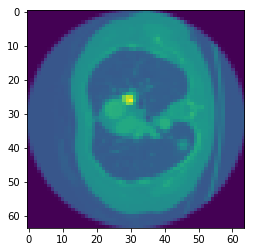

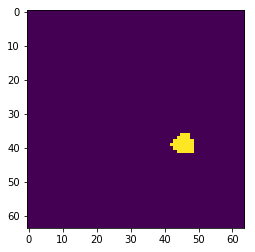

In [104]:
plt.imshow(data_resized[:,:,k_to_z[-122.5]])
plt.show()
plt.imshow(y_resized[:,:,k_to_z[-122.5]])
plt.show()

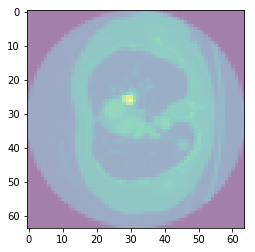

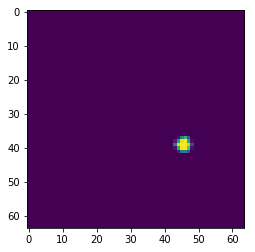

In [93]:
plt.imshow(scipy.misc.imresize(data[:,:, k_to_z[-122.5]], (64, 64)), alpha=0.5)
plt.show()
plt.imshow(scipy.misc.imresize(y[:,:, k_to_z[-122.5]], (64, 64)))
plt.show()

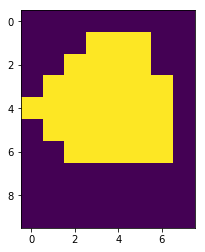

In [105]:
plt.imshow(scipy.misc.imresize(y_resized[:,:, k_to_z[-122.5]], (64, 64))[35:45, 42:50])
plt.show()

In [95]:
y_resize = scipy.misc.imresize(y[:,:, k_to_z[-122.5]], (64, 64))[35:45, 42:50]

In [107]:
y_resized[:,:,k_to_z[-122.5]][35:45, 42:50]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [97]:
np.where(y_resize > 0, 1, 0)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [128]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 1)         10        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 1)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 32, 32, 1)         5         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 64, 64, 1)         1090      
Total params: 1,105
Trainable params: 1,105
Non-trainable params: 0
_________________________________________________________________


510

In [98]:
data.shape

(512, 512, 133)

In [89]:
y.shape

(512, 512, 133)

In [61]:
resize(y[:,:,k_to_z[-122.5]].astype(int), (64, 64))

array([[  5.42101086e-20,   5.42101086e-20,   5.42101086e-20, ...,
          5.42101086e-20,   5.42101086e-20,   5.42101086e-20],
       [  5.42101086e-20,   5.42101086e-20,   5.42101086e-20, ...,
          5.42101086e-20,   5.42101086e-20,   5.42101086e-20],
       [  5.42101086e-20,   5.42101086e-20,   5.42101086e-20, ...,
          5.42101086e-20,   5.42101086e-20,   5.42101086e-20],
       ..., 
       [  5.42101086e-20,   5.42101086e-20,   5.42101086e-20, ...,
          5.42101086e-20,   5.42101086e-20,   5.42101086e-20],
       [  5.42101086e-20,   5.42101086e-20,   5.42101086e-20, ...,
          5.42101086e-20,   5.42101086e-20,   5.42101086e-20],
       [  5.42101086e-20,   5.42101086e-20,   5.42101086e-20, ...,
          5.42101086e-20,   5.42101086e-20,   5.42101086e-20]])

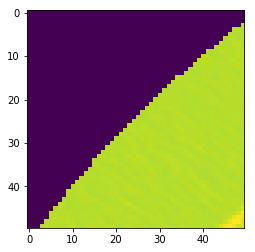

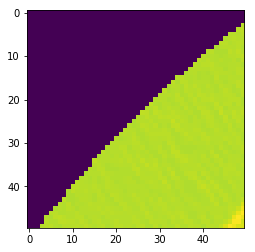

In [68]:
plt.imshow(data.T[0,50:100,50:100])
plt.show()
plt.imshow(data[50:100,50:100,0])
plt.show()

In [18]:
from PIL import Image

In [20]:
image = Image.open("image.jpeg")

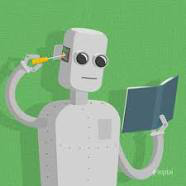

In [23]:
image

In [24]:
image.size

(186, 186)

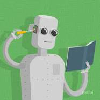

In [27]:
image.resize((100, 100))